In [161]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import random

### Calibration

In [162]:
"""
For each file, look for corners. If found, save image and corners.
Object points explanation here: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a30f45cb-c1c0-482c-8e78-a26604841ec0
"""
def calibrate(directory=''):
    objp = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    pathname = directory + '/*.jpg'
    fnames = glob.glob(pathname)
    objpoints = []
    imgpoints = []
    images = []
    for fname in fnames:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            imgpoints.append(corners)
            images.append(img)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist, images, imgpoints

In [163]:
"""
Calibrate the camera
"""
mtx, dist, images, imgpoints = calibrate('camera_cal')

### Visualize images

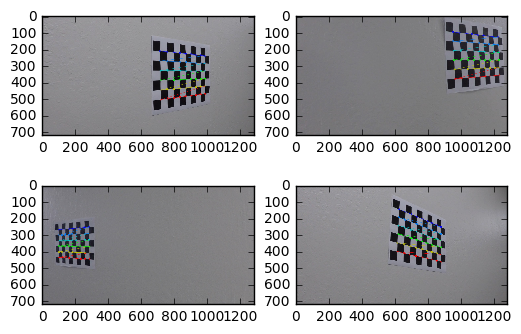

In [164]:
"""
Four random images before undistortion, with corners drawn
"""
for a in range(1,5):
    i = random.randint(0, len(images)-1)
    
    img_drawn = np.copy(images[i])
#     img_drawn = np.empty_like(images[i])
#     img_drawn[:] = images[i]
    
    corners = imgpoints[i]
    
    plt.subplot(2,2,a)
    img_drawn = cv2.drawChessboardCorners(img_drawn, (9,6), corners, True)
    
    plt.imshow(img_drawn)

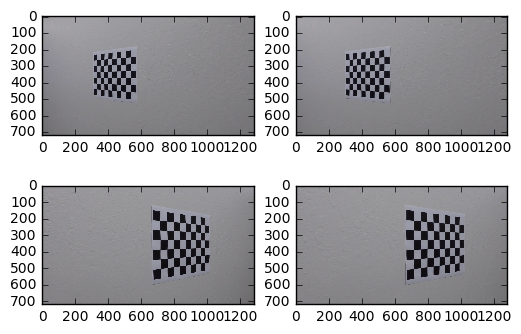

In [165]:
"""
Draw before and after undistortion for 2 images at random
"""
for a in range(1,4,2):
    i = random.randint(0, len(images)-1)
    img = images[i]
    
    plt.subplot(2,2,a)
    plt.imshow(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(2,2,a+1)
    plt.imshow(dst)

### Image processing functions

#### Gradient thresholding

In [480]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    """
    Returns binary of pixels
    within threshold for absolute x or y sobel
    for grayscale of the img
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [504]:
def sobel_sat(img):
    """
    Returns binary of pixels
    within threshold for absolute x and y sobels
    for saturation channel only
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,2]
    
    x = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=3))
    y = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=3))
    
    scaled_x = np.uint8(255*x/np.max(x))
    scaled_y = np.uint8(255*y/np.max(y))
    
    binary_output = np.zeros_like(scaled_x)
    binary_output[(scaled_x >= 20) & 
                  (scaled_x <= 255) & 
                  (scaled_y >= 20) &
                  (scaled_y <= 255)] = 1
    return binary_output

In [ ]:
# img = mpimg.imread('test_images/test5.jpg')
# binary = sobel_sat(img)
# plt.subplot(2,1,1)
# plt.imshow(img)
# plt.subplot(2,1,2)
# plt.imshow(binary,cmap='gray')

In [491]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """
    Returns binary of pixels
    within threshold for magnitude of sobel
    for grayscale of the image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return mag_binary

In [510]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Returns binary of pixels
    within threshold for direction of sobel
    for grayscale of the image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

#### Yellow and white thresholding

In [513]:
def yellow_mask(img):
    """
    Returns binary of pixels where yellow color is detected
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = img_hsv[:,:,0]
    S = img_hsv[:,:,1]
    V = img_hsv[:,:,2]
    
    H_bin = np.zeros_like(S)
    S_bin = np.zeros_like(S)
    V_bin = np.zeros_like(S)
    yellow_bin = np.zeros_like(S)
    
    # yellow
    H_bin[(H > 0) & (H <= 50)] = 1
    S_bin[(S > 100) & (S <= 255)] = 1
    V_bin[(V > 100) & (V <= 255)] = 1

    yellow_bin[(H_bin == 1) & (S_bin == 1) & (V_bin == 1)] = 1
    
    return yellow_bin

In [514]:
def white_mask(img):
    """
    Returns binary of pixels where white color is detected
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = img_hsv[:,:,0]
    S = img_hsv[:,:,1]
    V = img_hsv[:,:,2]
    
    H_bin = np.zeros_like(S)
    S_bin = np.zeros_like(S)
    V_bin = np.zeros_like(S)
    white_bin = np.zeros_like(S)
    
    # white
    H_bin[(H > 0) & (H <= 255)] = 1
    S_bin[(S > 0) & (S <= 30)] = 1
    V_bin[(V > 200) & (V <= 255)] = 1
    
    white_bin[(H_bin == 1) & (S_bin == 1) & (V_bin == 1)] = 1
    
    return white_bin

In [521]:
def white_and_yellow(img):
    """
    Returns binary of pixels where either yellow or white color is detected
    """
    white = white_mask(img)
    yellow = yellow_mask(img)
    dst = white + yellow
    return dst

In [518]:
# img = mpimg.imread('test_images/test3.jpg')
# binary = white_and_yellow(img)
# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.subplot(1,2,2)
# plt.imshow(binary,cmap='gray')

#### Saturation threshold

In [522]:
def sat_threshold(img, thresh=(0, 255)):
    """
    Returns binary of pixels where saturation is within threshold
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = gray[:,:,2]
    sat_binary = np.zeros_like(S)
    sat_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return sat_binary

In [524]:
# img = mpimg.imread('test_images/test3.jpg')
# binary = sat_threshold(img,(150,255))
# plt.imshow(binary,cmap='gray')


#### Combining methods into binary image

In [555]:
def binary_image(img):
    """
    Returns binary image 
    """
    
#     ksize=context['ksize']
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=context['gradx_thresh'])
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=context['grady_thresh'])
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=context['mag_binary_thresh'])
#     dir_binary = dir_threshold(img, sobel_kernel=15, thresh=context['dir_binary_thresh'])
#     sat_binary = sat_threshold(img, thresh=context['sat_binary_thresh'])
#     red_binary = red_threshold(img,thresh=context['red_binary_thresh'])
    w_y_binary = white_and_yellow(img)
    sobel_sat_binary = sobel_sat(img)
    combined = np.zeros_like(sobel_sat_binary)
    combined[(w_y_binary == 1) | (sobel_sat_binary == 1)] = 1
    return combined

#### Perspective transform

In [543]:
def transform_perspective(img):
    """
    Returns bird's eye view of image
    Based on callibration work end of this notebook
    """
    rows = img.shape[0]
    cols = img.shape[1]
    img_size = (cols, rows)
    slope_right = 0.6738857501569366
    slope_left = slope_right * -1
    delta_x = 0.3

    bl = (cols*0.15,rows)
    tl = (cols*(0.15+delta_x),rows + cols*(delta_x)*slope_left)
    br = (cols*0.88,rows)
    tr = (cols*(0.88-delta_x),rows + cols*(-delta_x)*slope_right)

    src = np.float32([[bl[0],bl[1]],[tl[0],tl[1]],[tr[0],tr[1]],[br[0],br[1]]])
    dst = np.float32([[bl[0],bl[1]],[bl[0],0],[br[0],0],[br[0],br[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped,Minv

In [544]:
def inverse_transform_perspective(img,Minv):
    """
    Wrapper that performs perspective transform to unwarp image
    """
    rows = img.shape[0]
    cols = img.shape[1]
    img_size = (cols, rows)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

#### Select points that are part of lines

In [545]:
def largest_column(img):
    """
    Sums image columns and returns the index of the largest column
    """
    histogram = np.sum(img, axis=0)
    index = np.argmax(histogram)
    return index

In [546]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [547]:
def find_line(img,vert_initial=None):
    """
    Find lane line in a binary image
    with moving window from bottom (minus 75 pixels for hood),
    return masked image
    
    If no initial mask vertices are provided, consider entire image region of interest
    For each vertical step up through image:
        Get line location
        Update line mask
        Step up creating a new ROI near the line location
    """

    rows, cols = img.shape[0], img.shape[1]
    line_mask = np.zeros_like(img)
    keep_h = 0.1*rows
    keep_w = 0.05*cols
    roi_h = 0.1*cols
    roi_w = 0.1*cols
    step = 0.1*rows
    
    # set initial ROI
    if(vert_initial == None):
        vert_initial = np.array([[(0,rows),(0,0),(cols,0),(cols,rows)]], dtype=np.int32)
    roi = region_of_interest(img,vert_initial)
    line_loc = 0
    
    # loop through
    for bottom in range(rows-75, 0, int(-1*step)):
        line_loc_candidate = largest_column(roi)
        if(line_loc_candidate != 0):
            line_loc = line_loc_candidate
        vert_keep = np.array([[(line_loc-keep_w/2,bottom),
                          (line_loc-keep_w/2,bottom-keep_h),
                          (line_loc+keep_w/2,bottom-keep_h),
                          (line_loc+keep_w/2,bottom)]], dtype=np.int32)
        line_window = region_of_interest(np.ones_like(img),vert_keep)
        line_mask[line_window == 1] = 1
        vert_roi = np.array([[(line_loc-roi_w/2,bottom),
                          (line_loc-roi_w/2,bottom-roi_h),
                          (line_loc+roi_w/2,bottom-roi_h),
                          (line_loc+roi_w/2,bottom)]], dtype=np.int32) 
        roi = region_of_interest(img,vert_roi)

    dst = line_mask*img
    return dst

In [548]:
def find_lines(img):
    """
    Returns both left and right lines
    """
    rows, cols = img.shape[0], img.shape[1]
    vert_left = np.array([[(0,rows),(0,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    vert_right = np.array([[(cols,rows),(cols,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    dst_l = find_line(img,vert_initial=vert_left)
    dst_r = find_line(img,vert_initial=vert_right)
    dst = dst_l+dst_r
    return dst

#### Measure curvature

In [549]:
def fit_line(img):
    """
    Return polynomial fit coefficients and x/y values
    """
    points = np.nonzero(img)
    if(points[0].size == 0):
        return None,None,None
    yvals, xvals = points[0], points[1]

    fit = np.polyfit(yvals, xvals, 2)

    fity = np.arange(img.shape[0])
    fitx = fit[0]*fity**2 + fit[1]*fity + fit[2]
    
    return fit,fitx,fity

#### Draw lane

In [550]:
def draw_lane(img,warped,Minv):
    """
    Returns an image with the lane colored in after unwarping it
    """
    rows, cols = img.shape[0], img.shape[1]
    vert_left = np.array([[(0,rows),(0,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    vert_right = np.array([[(cols,rows),(cols,0),(cols/2,0),(cols/2,rows)]], dtype=np.int32)
    warped_left = region_of_interest(warped,vert_left)
    warped_right = region_of_interest(warped,vert_right)

    # Create an img to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    fit_left,fitx_left,fity_left = fit_line(warped_left)
    fit_right,fitx_right,fity_right = fit_line(warped_right)
    curvature = 0
    if(fit_left != None and fit_right != None):

    #     left_curvature = curvature(fit_left,np.max(fity_left))
    #     right_curvature = curvature(fit_right,np.max(fity_right))

        left_curvature = ((1 + (2*fit_left[0]*np.max(fity_left) + fit_left[1])**2)**1.5) \
                                 /np.absolute(2*fit_left[0])
        right_curvature = ((1 + (2*fit_right[0]*np.max(fity_right) + fit_right[1])**2)**1.5) \
                                 /np.absolute(2*fit_right[0])
        curvature = (left_curvature + right_curvature)/2

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([fitx_left, fity_left]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([fitx_right, fity_right])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank img
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original img space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original img
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result,curvature

### Image pipeline

In [551]:
def image_pipeline(img,mtx,dist,left=None,right=None):
    """
    Returns lane boundaries, curvature, vehicle position, and left/right line objects
    
    Steps:
    + undistortion
    + detecting points, creating binary image
    + transforming perspecive
    + selecting points that are part of lines
    - (as above, but get hints based on recent frames)
    + fitting curves, defining lane boundaries
    o determining curvature
    - sanity checks (l/r  similar curvature, their separation is reasonable, l/r parallel, too few pixels, polyfit coefficients changed too much)
    - if doesn't pass check, use previous image. enough times in a row, then ignore recent frames
    - smooth over past n
    - updating line objects
    + drawing lanes
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    transformed,Minv = transform_perspective(binary)
    lines = find_lines(transformed)
    lane,curvature = draw_lane(img,lines,Minv)
    
    lanes = None
    curvature = None
    position = None
    return undist,binary,transformed,lines,lane,curvature

In [552]:
def process_image(img):
    undist,binary,transformed,lines,lane,curvature = \
        image_pipeline(img,mtx,dist,left=None,right=None)
    return lane

### Movies

In [553]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Test on movie

In [556]:
output_name = 'output_images/output_vy_short.mp4'
clip0 = VideoFileClip('short_video.mp4')
white_clip = clip0.fl_image(process_image)
%time white_clip.write_videofile(output_name, audio=False, codec='mpeg4')

[MoviePy] >>>> Building video output_images/output_vy_short.mp4
[MoviePy] Writing video output_images/output_vy_short.mp4






  0%|          | 0/215 [00:00<?, ?it/s]



  0%|          | 1/215 [00:00<00:58,  3.65it/s]



  1%|          | 2/215 [00:00<00:57,  3.73it/s]



  1%|▏         | 3/215 [00:00<00:55,  3.82it/s]



  2%|▏         | 4/215 [00:00<00:52,  4.00it/s]



  2%|▏         | 5/215 [00:01<00:51,  4.05it/s]



  3%|▎         | 6/215 [00:01<00:51,  4.05it/s]



  3%|▎         | 7/215 [00:01<00:51,  4.01it/s]



  4%|▎         | 8/215 [00:01<00:50,  4.06it/s]



  4%|▍         | 9/215 [00:02<00:48,  4.21it/s]



  5%|▍         | 10/215 [00:02<00:47,  4.32it/s]



  5%|▌         | 11/215 [00:02<00:49,  4.16it/s]



  6%|▌         | 12/215 [00:02<00:49,  4.06it/s]



  6%|▌         | 13/215 [00:03<00:49,  4.12it/s]



  7%|▋         | 14/215 [00:03<00:51,  3.90it/s]



  7%|▋         | 15/215 [00:03<00:49,  4.03it/s]



  7%|▋         | 16/215 [00:03<00:48,  4.08it/s]



  8%|▊         | 17/215 [00:04<00:48,  4.09it/s]



  8%|▊         | 18/215 [00:04<00:52,  3.79it/s]



  9%|▉         | 19/215 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_vy_short.mp4 

CPU times: user 1min 33s, sys: 8 s, total: 1min 41s
Wall time: 52.9 s


### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

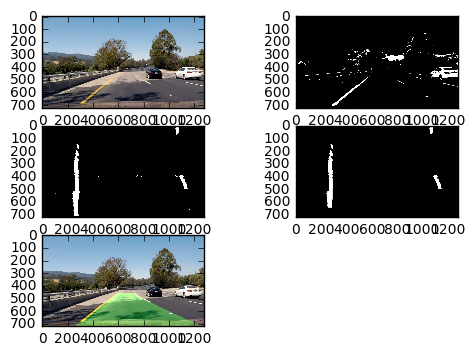

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

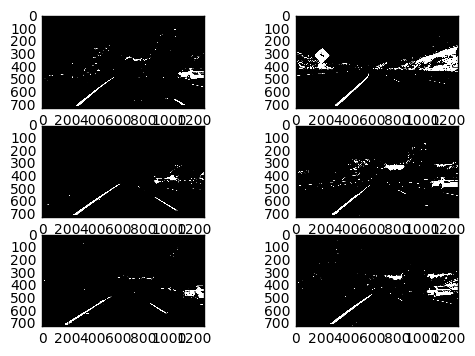

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

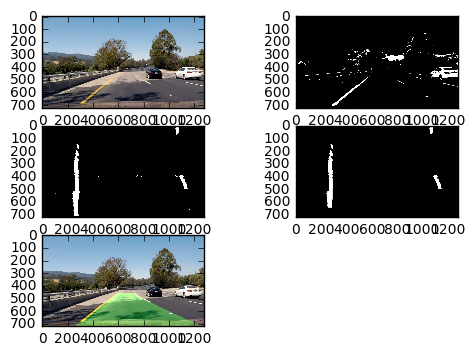

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

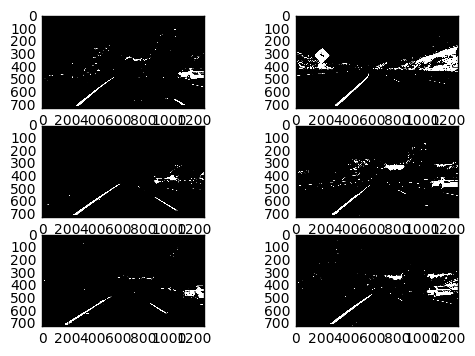

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

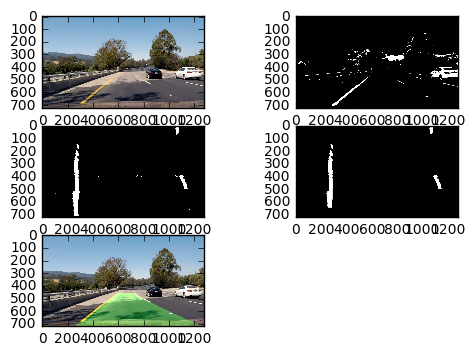

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

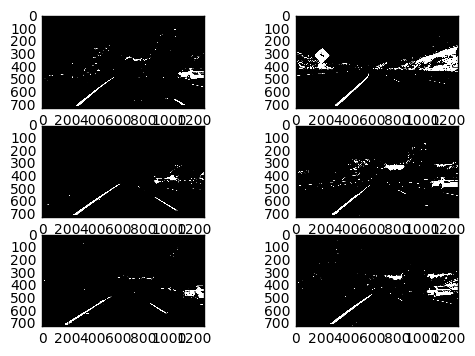

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

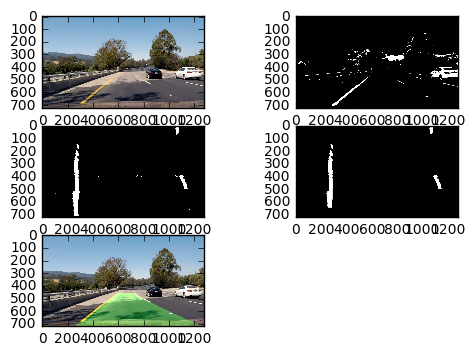

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

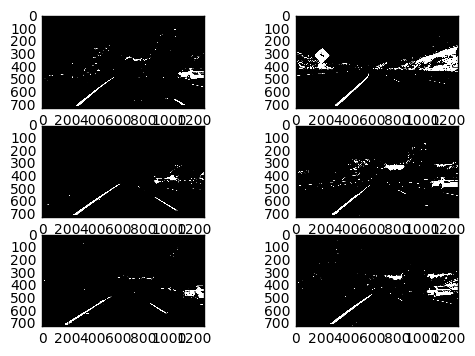

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

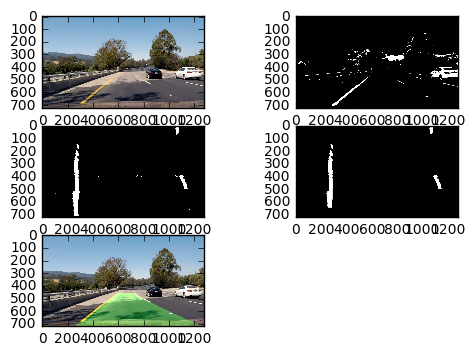

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

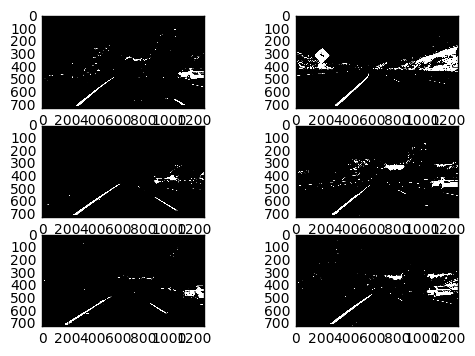

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

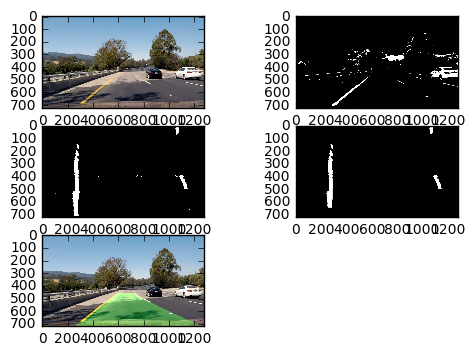

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

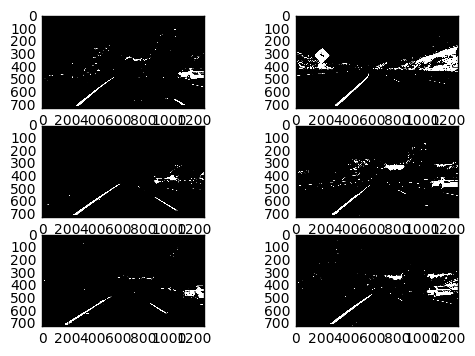

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

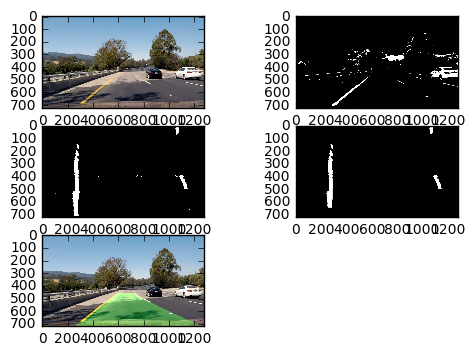

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

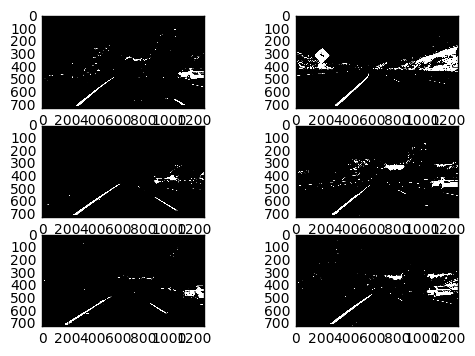

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

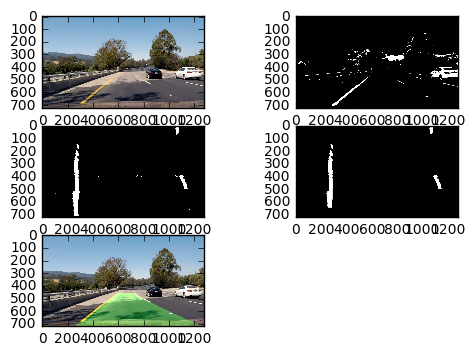

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

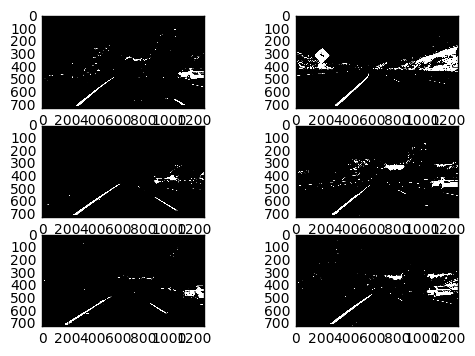

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

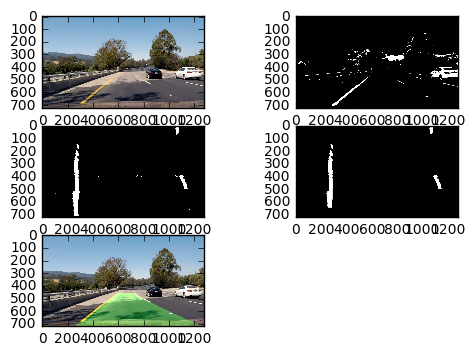

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

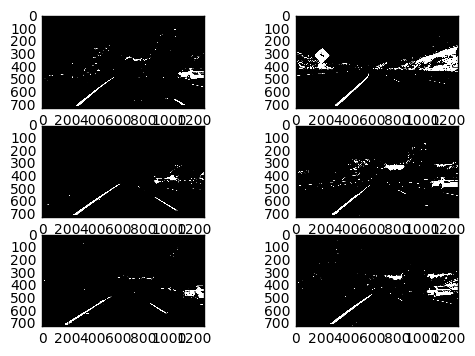

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

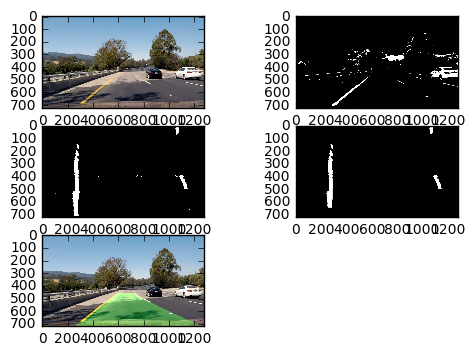

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

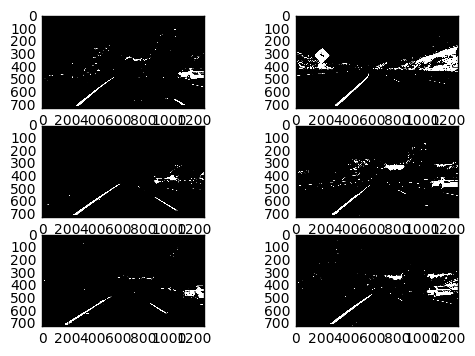

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')

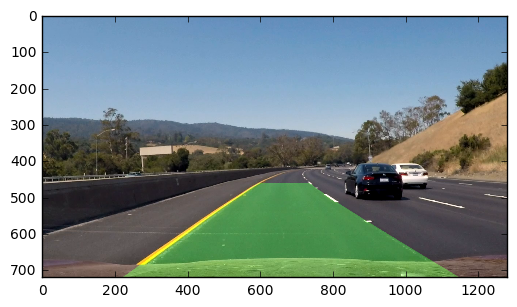

In [148]:
clip1 = VideoFileClip("short_video.mp4")
myframe = clip1.get_frame(1000)
fin = process_image(myframe)
plt.imshow(fin)

### Scratch

#### Figure out src and dst points for perspective transform

In [ ]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img)
plt.plot(145,540,'.')
plt.plot(415,350,'.')
plt.plot(555,350,'.')
plt.plot(850,540,'.')
# to help define perspective transform, eyeball some points and get the approximate slopes
abs_slope_left = abs((350-540)/(415-145))
abs_slope_right = abs((350-540)/(555-850))
avg_slope = (abs_slope_left + abs_slope_right)/2
print(avg_slope)

In [ ]:
img = mpimg.imread('test_images/test1.jpg')
rows = img.shape[0]
cols = img.shape[1]
img_size = (cols, rows)

slope_right = 0.6738857501569366
slope_left = slope_right * -1

delta_x = 0.3 #.34

bl = (cols*0.15,rows)
tl = (cols*(0.15+delta_x),rows + cols*(delta_x)*slope_left)

br = (cols*0.88,rows)
tr = (cols*(0.88-delta_x),rows + cols*(-delta_x)*slope_right)

plt.subplot(2,2,1)
plt.imshow(img)
plt.plot(bl[0],bl[1],'.')
plt.plot(tl[0],tl[1],'.')
plt.plot(br[0],br[1],'.')
plt.plot(tr[0],tr[1],'.')

src = np.float32([[bl[0],bl[1]],[tl[0],tl[1]],[tr[0],tr[1]],[br[0],br[1]]])
dst = np.float32([[bl[0],bl[1]],[bl[0],0],[br[0],0],[br[0],br[1]]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.subplot(2,2,2)
plt.imshow(img)
plt.plot(bl[0],bl[1],'.')
plt.plot(bl[0],0,'.')
plt.plot(br[0],br[1],'.')
plt.plot(br[0],0,'.')

plt.subplot(2,2,3)
plt.imshow(warped)

In [ ]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
print(img.shape)
img_size = (img.shape[1], img.shape[0]) # number of columns comes first for warpPerspective
plt.imshow(img)
src = np.float32([[275,720],[500,550],[860,550],[1150,720]])
dst = np.float32([[275,720],[275,0],[1150,0],[1150,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(img)
plt.plot(145,540,'.')
plt.plot(415,350,'.')
plt.plot(555,350,'.')
plt.plot(850,540,'.')

print((350-540)/(415-145))
print((350-540)/(555-850))
plt.imshow(warped)

Pre-processing:
- Calibration

Image pipeline:
- Distortion correction
- Create binary image (gradients, colors, masks, etc)
- Perspective transform
- Pick out the lane lines
- Determine curvature
- Transform boundaries back to original image

In [ ]:
def process_video():
    get_frame()
    
    if(fail_count > max_fail):
        locked = False
        fail_count = 0
        
    if(locked):
        smart_search()
        if(sanity_check()):
            update_line()
        else:
            use last frame
            update fail count
    else:
        blind_search()

In [ ]:
import numpy as np
# Generate some fake data to represent lane-line pixels
yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                              for idx, elem in enumerate(yvals)])
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                                for idx, elem in enumerate(yvals)])
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(yvals, leftx, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fit = np.polyfit(yvals, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

# Plot up the fake data
plt.plot(leftx, yvals, 'o', color='red')
plt.plot(rightx, yvals, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

In [ ]:
img = mpimg.imread('test_images/test1.jpg')
plt.subplot(3,2,1)
plt.imshow(img)

img = mpimg.imread('test_images/test2.jpg')
plt.subplot(3,2,2)
plt.imshow(img)

img = mpimg.imread('test_images/test3.jpg')
plt.subplot(3,2,3)
plt.imshow(img)

img = mpimg.imread('test_images/test4.jpg')
plt.subplot(3,2,4)
plt.imshow(img)

img = mpimg.imread('test_images/test5.jpg')
plt.subplot(3,2,5)
plt.imshow(img)

img = mpimg.imread('test_images/test6.jpg')
plt.subplot(3,2,6)
plt.imshow(img)

In [ ]:
def red_threshold(img, thresh=(0, 255)):
    """
    Returns binary of pixels where red is within threshold
    Not as effective as yellow and white detection via HSV
    """
    R = img[:,:,0]
    dst = np.zeros_like(R)
    dst[(R > thresh[0]) & (R <= thresh[1])] = 1
    return dst

### Test: single image

In [ ]:
def test_binary(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binary_image(undist)
    return binary

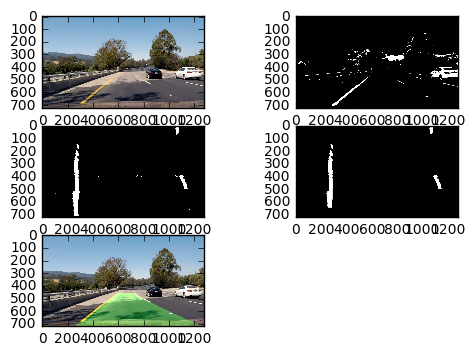

In [475]:
img = mpimg.imread('test_images/test4.jpg')
undist,binary,transformed,lines,lane,curvature = \
    image_pipeline(img,mtx,dist,left=None,right=None)
plt.subplot(3,2,1)
plt.imshow(img)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')
plt.subplot(3,2,3)
plt.imshow(transformed,cmap='gray')
plt.subplot(3,2,4)
plt.imshow(lines,cmap='gray')
plt.subplot(3,2,5)
plt.imshow(lane)

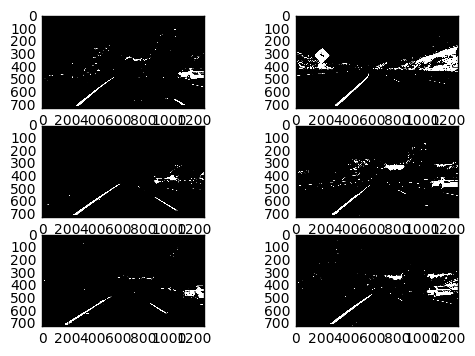

In [507]:
context = {'ksize':3,
           'gradx_thresh':(20,200),
           'grady_thresh':(20,200),
           'mag_binary_thresh':(20,200),
           'dir_binary_thresh':(1/3*np.pi/2, 2/3*np.pi/2),
           'sat_binary_thresh':(150,255),
           'red_binary_thresh':(230,255)}

"""
    combined[((gradx == 1) | (grady == 1) | (mag_binary == 1)) 
             & (dir_binary == 1) 
             | (sat_binary == 1)] = 1
"""

img = mpimg.imread('test_images/test1.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,1)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test2.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,2)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test3.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,3)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test4.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,4)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test5.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,5)
plt.imshow(binary,cmap='gray')

img = mpimg.imread('test_images/test6.jpg')
binary = test_binary(img,mtx,dist)
plt.subplot(3,2,6)
plt.imshow(binary,cmap='gray')